# DL training

## Setup

In [1]:
import numpy as np, pandas as pd
import os, random
from katlas.data import *
from katlas.train import *
from fastai.vision.all import *
from katlas.dnn import *

In [2]:
seed_everything()

In [3]:
def_device

'cuda'

## Data

In [4]:
df=pd.read_parquet('train/pspa_t5.parquet')

In [5]:
info=Data.get_kinase_info()

info = info[info.pseudo=='0']

info = info[info.kd_ID.notna()]

subfamily_map = info[['kd_ID','subfamily']].drop_duplicates().set_index('kd_ID')['subfamily']
family_map = info[['kd_ID','family']].drop_duplicates().set_index('kd_ID')['family']
group_map = info[['kd_ID','group']].drop_duplicates().set_index('kd_ID')['group']

pspa_info = pd.DataFrame(df.index.tolist(),columns=['kinase'])

pspa_info['subfamily'] = pspa_info.kinase.map(subfamily_map)
pspa_info['family'] = pspa_info.kinase.map(family_map)
pspa_info['group'] = pspa_info.kinase.map(group_map)

In [6]:
df=df.reset_index()

In [7]:
df.columns

Index(['index', '-5P', '-4P', '-3P', '-2P', '-1P', '0P', '1P', '2P', '3P',
       ...
       'T5_1014', 'T5_1015', 'T5_1016', 'T5_1017', 'T5_1018', 'T5_1019',
       'T5_1020', 'T5_1021', 'T5_1022', 'T5_1023'],
      dtype='object', length=1255)

In [8]:
# column name of feature and target
feat_col = df.columns[df.columns.str.startswith('T5_')]
target_col = df.columns[~df.columns.isin(feat_col)][1:]

In [9]:
feat_col

Index(['T5_0', 'T5_1', 'T5_2', 'T5_3', 'T5_4', 'T5_5', 'T5_6', 'T5_7', 'T5_8',
       'T5_9',
       ...
       'T5_1014', 'T5_1015', 'T5_1016', 'T5_1017', 'T5_1018', 'T5_1019',
       'T5_1020', 'T5_1021', 'T5_1022', 'T5_1023'],
      dtype='object', length=1024)

## Split

In [10]:
pspa_info.subfamily.value_counts()

subfamily
Eph      12
Src      11
NEK      10
CK1       7
STE11     7
         ..
ZAK       1
Sev       1
Ret       1
Musk      1
Tie       1
Name: count, Length: 149, dtype: int64

In [11]:
pspa_info.family.value_counts()

family
STE20    27
CAMKL    20
CDK      17
MAPK     12
Eph      12
         ..
STK33     1
Sev       1
Ret       1
Musk      1
Tie       1
Name: count, Length: 92, dtype: int64

In [12]:
pspa_info.group.value_counts()

group
TK          78
CAMK        57
CMGC        52
AGC         52
Other       49
STE         39
TKL         25
CK1         11
Atypical     5
Name: count, dtype: int64

In [13]:
splits = get_splits(pspa_info, group='group',nfold=9)

split0 = splits[0]

GroupKFold(n_splits=9, random_state=None, shuffle=False)
# group in train set: 8
# group in test set: 1


## Dataset

In [14]:
# dataset
ds = GeneralDataset(df,feat_col,target_col)

In [15]:
len(ds)

368

In [16]:
dl = DataLoader(ds, batch_size=64, shuffle=True)

In [17]:
xb,yb = next(iter(dl))

xb.shape,yb.shape

(torch.Size([64, 1024]), torch.Size([64, 23, 10]))

## Model

In [18]:
n_feature = len(feat_col)
n_target = len(target_col)

In [19]:

def get_mlp(): return PSSM_model(n_feature,n_target,model='MLP')

def get_cnn(): return PSSM_model(n_feature,n_target,model='CNN')

In [20]:
model = get_mlp()

In [21]:
logits= model(xb)

In [22]:
logits.shape

torch.Size([64, 23, 10])

## Loss

In [23]:
CE(logits,yb)

tensor(3.2301, grad_fn=<MeanBackward0>)

## Metrics

In [24]:
KLD(logits,yb)

tensor(0.4888, grad_fn=<MeanBackward0>)

In [25]:
JSD(logits,yb)

tensor(0.1021, grad_fn=<MeanBackward0>)

## Single split train

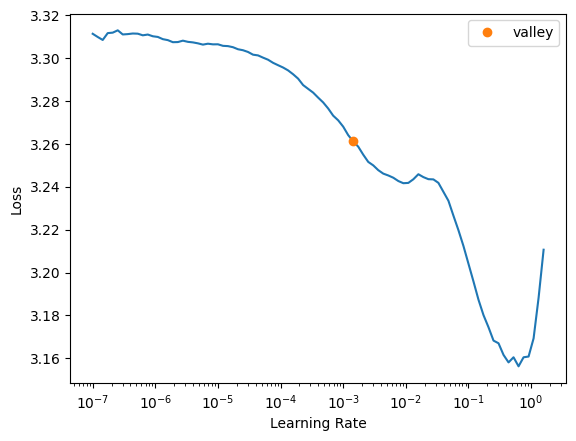

SuggestedLRs(valley=0.0014454397605732083)
lr in training is SuggestedLRs(valley=0.0014454397605732083)


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.285318,3.138410,0.399849,0.080903,00:00
1,3.251020,3.153299,0.414738,0.083310,00:00
2,3.221015,3.153386,0.414825,0.083951,00:00
3,3.190897,3.135373,0.396812,0.085170,00:00
4,3.161854,3.160003,0.421443,0.088640,00:00
5,3.140622,3.224034,0.485473,0.097176,00:00
6,3.117217,3.217723,0.479162,0.090662,00:00
7,3.096380,3.274236,0.535675,0.093382,00:00
8,3.068360,3.268202,0.529641,0.092203,00:00
9,3.037357,3.283351,0.544790,0.092823,00:00


In [26]:
target, pred = train_dl(df, 
                        feat_col, 
                        target_col,
                        split0, 
                        model_func=get_cnn,
                        n_epoch=30,
                        lr = 3e-3,
                        lr_find=True,
                        save = 'test')

In [27]:
from katlas.pssm import *

In [28]:
target_pssm = recover_pssm(target.iloc[0])
target_pssm.sum()

Position
-5    1.00002
-4    1.00001
-3    0.99998
-2    1.00002
-1    0.99999
 0    1.00000
 1    0.99999
 2    1.00001
 3    1.00000
 4    0.99999
dtype: float32

In [29]:
pred_pssm = recover_pssm(pred.iloc[0])
pred_pssm.sum()

Position
-5    1.0
-4    1.0
-3    1.0
-2    1.0
-1    1.0
 0    1.0
 1    1.0
 2    1.0
 3    1.0
 4    1.0
dtype: float32

<Axes: >

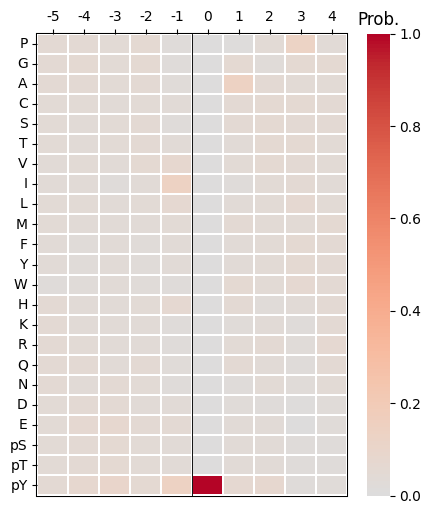

In [30]:
plot_heatmap(target_pssm)

<Axes: >

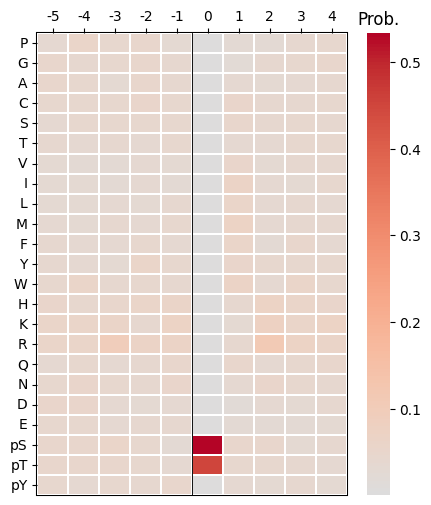

In [31]:
plot_heatmap(pred_pssm)

## CV train
> cross-validation

In [32]:
oof_cnn = train_dl_cv(df,feat_col,target_col,
                  splits = splits,
                  model_func = get_cnn,
                  n_epoch=20,lr=3e-3,save='cnn')

------fold0------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.267062,3.139845,0.401284,0.081106,00:00
1,3.223464,3.148611,0.410050,0.083931,00:00
2,3.185555,3.176406,0.437845,0.090488,00:00
3,3.159098,3.294427,0.555866,0.106696,00:00
4,3.140792,3.272541,0.533980,0.100772,00:00
5,3.108972,3.326859,0.588298,0.100043,00:00
6,3.067830,3.456511,0.717949,0.100769,00:00
7,3.026271,3.477726,0.739164,0.096296,00:00
8,2.988232,3.487863,0.749302,0.095987,00:02
9,2.956695,3.521343,0.782782,0.095385,00:00


------fold1------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.206308,3.134469,0.375076,0.081702,00:00
1,3.098244,3.014383,0.254990,0.063342,00:00
2,3.023023,2.900147,0.140755,0.033211,00:00
3,2.981518,2.878396,0.119003,0.028683,00:00
4,2.957600,2.882276,0.122883,0.029370,00:00
5,2.938779,2.875648,0.116255,0.027338,00:00
6,2.919317,2.861325,0.101932,0.024243,00:00
7,2.902320,2.871881,0.112489,0.026372,00:00
8,2.886668,2.874101,0.114708,0.026868,00:00
9,2.872254,2.886395,0.127002,0.029575,00:00


------fold2------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.214660,3.129669,0.413065,0.088715,00:00
1,3.106082,2.972016,0.255413,0.062623,00:00
2,3.027783,2.906785,0.190181,0.042072,00:00
3,2.985911,2.893852,0.177249,0.038721,00:00
4,2.962000,2.899944,0.183341,0.041446,00:00
5,2.943325,2.851114,0.134511,0.030394,00:00
6,2.924633,2.859588,0.142985,0.032340,00:00
7,2.908342,2.840279,0.123675,0.028687,00:00
8,2.891940,2.846087,0.129483,0.030347,00:00
9,2.878084,2.846339,0.129735,0.030608,00:00


------fold3------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.198622,3.130366,0.439222,0.092236,00:00
1,3.094114,2.985975,0.294830,0.066709,00:00
2,3.024600,2.921147,0.230003,0.047599,00:00
3,2.983457,2.949104,0.257960,0.050574,00:00
4,2.958015,2.928757,0.237613,0.049626,00:00
5,2.937352,2.942657,0.251513,0.046983,00:00
6,2.919618,2.924417,0.233273,0.044743,00:00
7,2.902185,2.922293,0.231149,0.044638,00:00
8,2.886426,2.941521,0.250377,0.046320,00:00
9,2.873229,2.943371,0.252226,0.046755,00:00


------fold4------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.209577,3.135238,0.345793,0.075424,00:00
1,3.096744,2.994096,0.204651,0.052508,00:00
2,3.021656,2.922113,0.132668,0.032070,00:00
3,2.982680,2.930365,0.140920,0.033077,00:00
4,2.960515,2.944075,0.154630,0.036434,00:00
5,2.938858,2.923111,0.133666,0.031424,00:00
6,2.915499,2.895575,0.106130,0.024865,00:00
7,2.895108,2.902996,0.113550,0.026362,00:00
8,2.878779,2.902032,0.112587,0.026021,00:00
9,2.864492,2.901900,0.112455,0.025933,00:00


------fold5------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.202675,3.131670,0.342859,0.074564,00:00
1,3.090040,2.980065,0.191255,0.049776,00:00
2,3.016258,2.923145,0.134334,0.032333,00:00
3,2.976347,2.917092,0.128281,0.030950,00:00
4,2.950565,2.901941,0.113130,0.027872,00:00
5,2.929346,2.898371,0.109560,0.027108,00:00
6,2.907545,2.895530,0.106720,0.026316,00:00
7,2.887915,2.883490,0.094680,0.023160,00:00
8,2.871519,2.881904,0.093093,0.022510,00:00
9,2.857392,2.894007,0.105196,0.025501,00:00


------fold6------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.191475,3.119970,0.304703,0.069725,00:00
1,3.077376,2.961124,0.145858,0.039012,00:00
2,3.004788,2.939052,0.123785,0.028735,00:00
3,2.968581,2.968269,0.153002,0.035989,00:00
4,2.949740,2.970083,0.154817,0.036244,00:00
5,2.931648,2.928213,0.112946,0.025595,00:00
6,2.911798,2.905435,0.090169,0.021492,00:00
7,2.893174,2.926265,0.110999,0.024887,00:00
8,2.875736,3.019296,0.204030,0.039461,00:00
9,2.860998,3.037610,0.222344,0.041589,00:00


------fold7------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.205762,3.125518,0.463472,0.099446,00:00
1,3.090994,2.932461,0.270415,0.061388,00:00
2,3.012133,2.992717,0.330672,0.066662,00:00
3,2.971220,2.978162,0.316116,0.066768,00:00
4,2.947923,2.989294,0.327248,0.067326,00:00
5,2.927150,3.007951,0.345906,0.073003,00:00
6,2.906955,3.005987,0.343942,0.074249,00:00
7,2.890937,2.954131,0.292086,0.063300,00:00
8,2.875597,2.944746,0.282701,0.066500,00:00
9,2.861912,2.957543,0.295497,0.064030,00:00


------fold8------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.201532,3.119269,0.321137,0.070999,00:00
1,3.083373,2.954438,0.156306,0.038102,00:00
2,3.009263,2.923135,0.125003,0.027480,00:00
3,2.970518,2.925437,0.127305,0.027335,00:00
4,2.949522,2.910274,0.112142,0.024042,00:00
5,2.929737,2.924637,0.126505,0.027216,00:00
6,2.911325,2.933999,0.135867,0.029482,00:00
7,2.893082,2.927606,0.129474,0.028129,00:00
8,2.877554,2.905413,0.107282,0.023756,00:00
9,2.862783,2.918824,0.120693,0.026281,00:00


In [33]:
oof_mlp = train_dl_cv(df,feat_col,target_col,
                  splits = splits,
                  model_func = get_mlp,
                  n_epoch=20,lr=3e-3,save='mlp')

------fold0------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.166903,3.132879,0.394318,0.080319,00:00
1,3.102524,3.138306,0.399745,0.081233,00:00
2,3.034962,3.155424,0.416863,0.083631,00:00
3,2.973157,3.209394,0.470833,0.086907,00:00
4,2.926999,3.306511,0.567950,0.089080,00:00
5,2.894465,3.402725,0.664163,0.092419,00:00
6,2.870650,3.443558,0.704997,0.092919,00:00
7,2.852653,3.442792,0.704231,0.090977,00:00
8,2.838649,3.485746,0.747185,0.094963,00:00
9,2.827238,3.559226,0.820665,0.094873,00:00


------fold1------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.124558,3.130867,0.371475,0.081856,00:00
1,3.043257,3.102276,0.342883,0.078184,00:00
2,2.978374,3.029924,0.270531,0.066600,00:02
3,2.928314,2.933338,0.173945,0.045210,00:00
4,2.893618,2.878826,0.119434,0.029334,00:00
5,2.870343,2.865657,0.106264,0.025342,00:00
6,2.851998,2.863357,0.103964,0.024375,00:00
7,2.838034,2.873848,0.114455,0.026570,00:00
8,2.826964,2.862329,0.102936,0.023976,00:00
9,2.817655,2.866397,0.107005,0.025137,00:00


------fold2------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.131233,3.128881,0.412277,0.088860,00:00
1,3.048964,3.106204,0.389600,0.085920,00:00
2,2.985693,3.049377,0.332774,0.077685,00:00
3,2.935895,2.962811,0.246207,0.060838,00:00
4,2.902060,2.879312,0.162708,0.039849,00:00
5,2.877688,2.839090,0.122487,0.028610,00:00
6,2.859718,2.856529,0.139925,0.033544,00:00
7,2.845636,2.842166,0.125562,0.029014,00:00
8,2.834886,2.853456,0.136852,0.032096,00:00
9,2.825639,2.848170,0.131566,0.030038,00:00


------fold3------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.136296,3.136054,0.444910,0.093409,00:00
1,3.051196,3.121693,0.430549,0.091409,00:00
2,2.985028,3.068336,0.377192,0.082574,00:00
3,2.936955,3.003363,0.312219,0.068375,00:00
4,2.903770,2.950429,0.259285,0.053958,00:00
5,2.880152,2.928024,0.236880,0.046593,00:00
6,2.862936,2.936391,0.245247,0.047701,00:00
7,2.848995,2.929435,0.238291,0.045939,00:00
8,2.838091,2.923856,0.232712,0.046272,00:00
9,2.829025,2.948348,0.257204,0.050018,00:00


------fold4------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.147735,3.139209,0.349764,0.075800,00:00
1,3.057163,3.124315,0.334870,0.074138,00:00
2,2.988792,3.067544,0.278099,0.066134,00:00
3,2.936703,2.982773,0.193328,0.049829,00:00
4,2.899348,2.907543,0.118098,0.029733,00:00
5,2.872918,2.892864,0.103419,0.025146,00:00
6,2.853113,2.887438,0.097993,0.023217,00:00
7,2.838368,2.890180,0.100735,0.023453,00:00
8,2.826229,2.894118,0.104673,0.024213,00:00
9,2.817494,2.893627,0.104182,0.024453,00:00


------fold5------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.126716,3.134745,0.345934,0.074873,00:00
1,3.037725,3.110292,0.321481,0.071874,00:00
2,2.970698,3.055549,0.266739,0.064210,00:00
3,2.925403,2.986015,0.197204,0.050699,00:00
4,2.892010,2.945005,0.156194,0.039692,00:00
5,2.867216,2.920071,0.131260,0.033453,00:00
6,2.850868,2.956883,0.168072,0.042927,00:00
7,2.836814,2.907484,0.118674,0.028432,00:00
8,2.825377,2.915659,0.126848,0.030652,00:00
9,2.815855,2.894719,0.105909,0.026076,00:00


------fold6------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.121308,3.136481,0.321214,0.071511,00:00
1,3.037128,3.124637,0.309370,0.069931,00:00
2,2.971336,3.118304,0.303038,0.068639,00:00
3,2.920824,3.106384,0.291117,0.066480,00:00
4,2.886757,3.055446,0.240180,0.058492,00:00
5,2.863297,3.032389,0.217122,0.053869,00:00
6,2.845752,3.090359,0.275093,0.062046,00:00
7,2.832389,3.123152,0.307885,0.064842,00:00
8,2.821567,3.107343,0.292077,0.063214,00:00
9,2.812597,3.083051,0.267784,0.060378,00:00


------fold7------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.120271,3.130176,0.468130,0.099971,00:00
1,3.032116,3.105953,0.443907,0.097196,00:00
2,2.965791,3.030176,0.368131,0.085198,00:00
3,2.917884,2.937019,0.274973,0.064035,00:00
4,2.885356,2.884802,0.222756,0.050772,00:00
5,2.862930,2.893450,0.231405,0.052646,00:00
6,2.846106,2.917146,0.255100,0.060252,00:00
7,2.832899,2.914746,0.252700,0.058480,00:00
8,2.822408,2.900075,0.238030,0.057313,00:00
9,2.813979,2.912257,0.250211,0.060137,00:00


------fold8------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.114418,3.131630,0.333498,0.072590,00:00
1,3.031310,3.114955,0.316823,0.070676,00:00
2,2.966872,3.066489,0.268357,0.063583,00:02
3,2.916370,3.022854,0.224722,0.055221,00:00
4,2.883500,2.982928,0.184796,0.045907,00:00
5,2.861376,3.016049,0.217918,0.053137,00:00
6,2.844419,3.012721,0.214589,0.051870,00:00
7,2.831247,3.079105,0.280973,0.063790,00:00
8,2.820517,3.070037,0.271905,0.062553,00:00
9,2.812295,3.069052,0.270920,0.062231,00:00


## Score

In [34]:
from katlas.clustering import *

from functools import partial

In [35]:
def score_df(target,pred,func):
    distance = [func(target.loc[i],pred.loc[i,target.columns]) for i in target.index]
    return pd.Series(distance,index=target.index)

In [36]:
jsd_df = partial(score_df,func=js_divergence_flat)
kld_df = partial(score_df,func=kl_divergence_flat)

In [37]:
def calculate_ce(pred_series,target_series):
    return float((-(np.log(recover_pssm(pred_series))*(recover_pssm(target_series))).sum()).mean())

In [38]:
def ce_df(target_df,pred_df):
    results=[]
    for i in pred_df.index:
        pred_series = pred_df.loc[i,target_df.columns]
        target_series = target_df.loc[i]
        results.append(calculate_ce(pred_series,target_series))
    return results

In [39]:
target=df[target_col].copy()

In [40]:
pspa_info['split'] = oof_cnn.nfold

In [41]:
pspa_info['mlp'] =jsd_df(target,oof_mlp)
pspa_info['cnn'] =jsd_df(target,oof_cnn)

In [42]:
from katlas.plot import *

In [43]:
set_sns()

In [44]:
pspa_info[['mlp','cnn']].describe()

,mlp,cnn
count,368.000000,368.000000
mean,0.046829,0.044541
std,0.029880,0.030001
min,0.006330,0.005110
25%,0.023094,0.022167
50%,0.034995,0.031304
75%,0.066988,0.060310
max,0.119516,0.121848


In [58]:
pspa_info

,kinase,subfamily,family,group,split,mlp,cnn,ce_mlp,ce_cnn
0,Q2M2I8_AAK1_HUMAN_KD1,NAK,NAK,Other,4,0.046863,0.048832,2.877453,2.874400
1,P27037_AVR2A_HUMAN_KD1,STKR2,STKR,TKL,6,0.051495,0.028318,2.990516,2.923527
2,Q13705_AVR2B_HUMAN_KD1,STKR2,STKR,TKL,6,0.047273,0.036483,2.977244,2.958024
3,P31749_AKT1_HUMAN_KD1,Akt,Akt,AGC,2,0.028149,0.022024,2.780833,2.758668
4,P31751_AKT2_HUMAN_KD1,Akt,Akt,AGC,2,0.018557,0.015202,2.765156,2.752341
...,...,...,...,...,...,...,...,...,...
363,P17948_VGFR1_HUMAN_KD1,VEGFR,VEGFR,TK,0,0.090280,0.086438,3.577618,3.614759
364,P35968_VGFR2_HUMAN_KD1,VEGFR,VEGFR,TK,0,0.085034,0.085111,3.560390,3.610411
365,P35916_VGFR3_HUMAN_KD1,VEGFR,VEGFR,TK,0,0.087957,0.089717,3.556659,3.606443
366,P07947_YES_HUMAN_KD1,Src,Src,TK,0,0.096889,0.092892,3.642280,3.607300


Text(0.5, 1.0, 'Comparison of models')

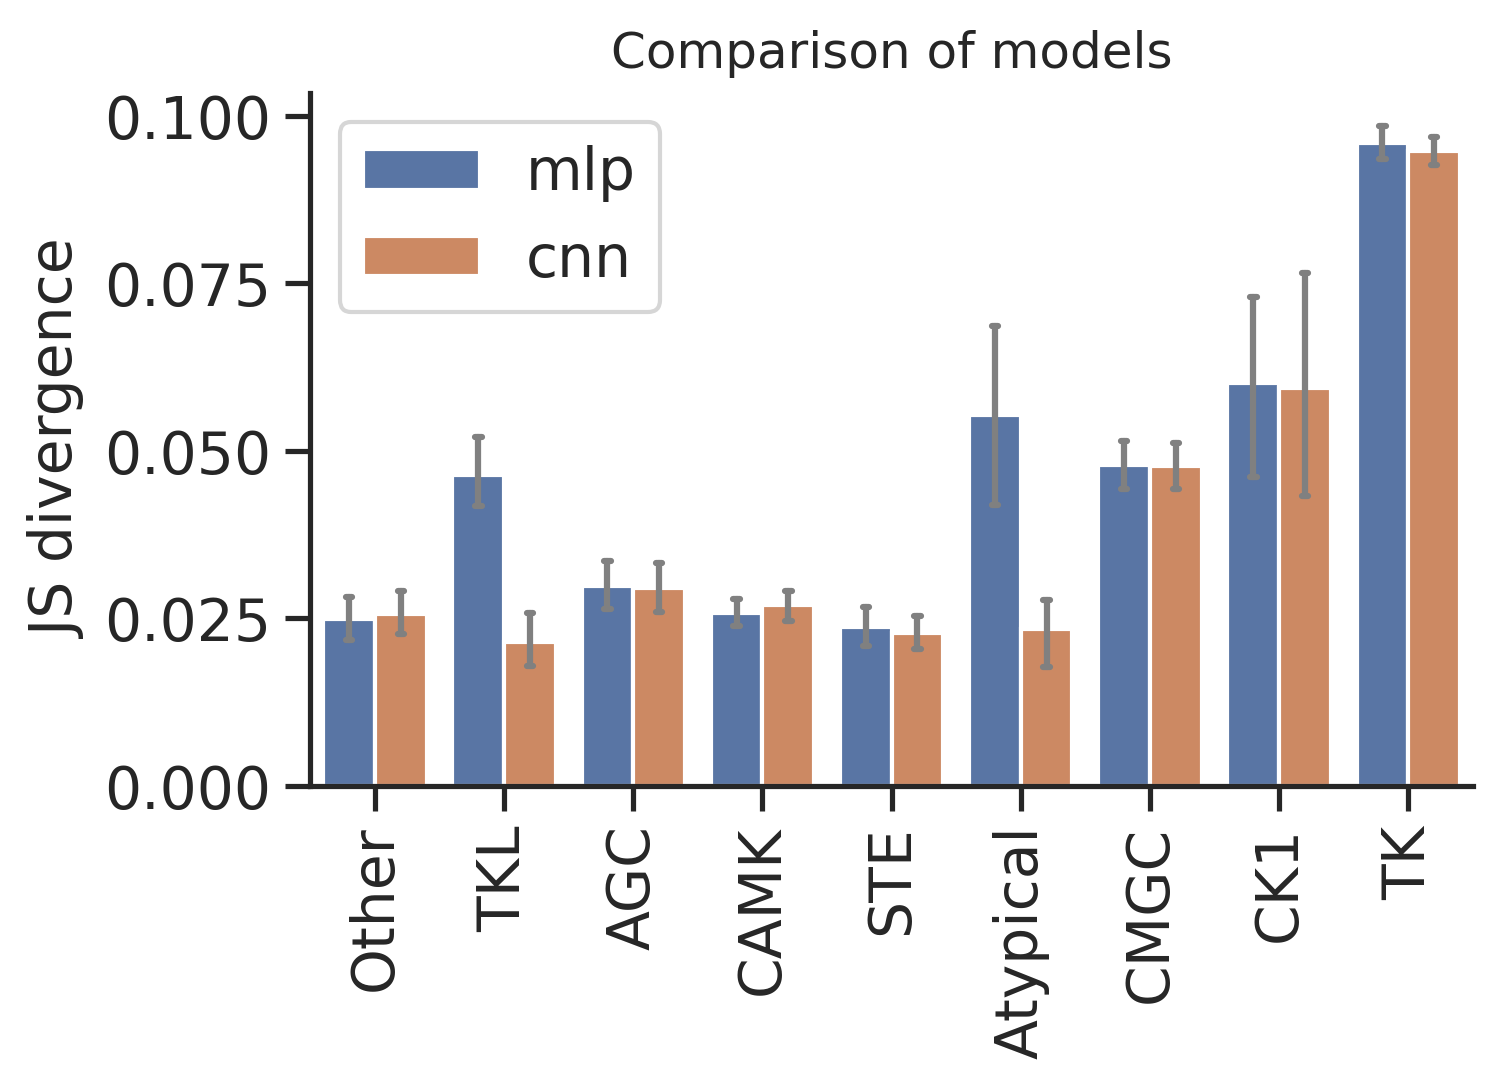

In [59]:
plot_group_bar(pspa_info,['mlp','cnn'],group='group',figsize=(5,3))
plt.ylabel('JS divergence')
plt.title('Comparison of models')

In [62]:
pspa_info['ce_mlp'] = ce_df(target,oof_mlp)

In [63]:
pspa_info.groupby('split').ce_mlp.mean()

split
0    3.619988
1    2.870603
2    2.844891
3    2.942088
4    2.896040
5    2.886665
6    2.997839
7    2.916453
8    3.035037
Name: ce_mlp, dtype: float64

In [50]:
pspa_info['ce_cnn'] = ce_df(target,oof_cnn)

In [51]:
pspa_info.groupby('split').ce_cnn.mean()

split
0    3.613761
1    2.874424
2    2.842776
3    2.947514
4    2.900240
5    2.882300
6    2.906933
7    2.928714
8    2.904138
Name: ce_cnn, dtype: float64

In [52]:
pspa_info.groupby('split').ce_mlp.mean()

split
0    3.619988
1    2.870603
2    2.844891
3    2.942088
4    2.896040
5    2.886665
6    2.997839
7    2.916453
8    3.035037
Name: ce_mlp, dtype: float64